<a href="https://colab.research.google.com/github/ushham/GISTools/blob/main/GeoPandas_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Interactive Mapping
This notebook allows you to select a cycle trip, and will present an interactive map showing each camping spot, and the following days elevation chart.

Select a cycle trip by the year it occured.\
(2012, 2013, or 2015)

In [ ]:
year = 2015

We use the pip package manager to install geopandas which does all the heavy lifting in this project.

In [ ]:
!pip install geopandas

We link a folder in our google drive to the notepad to allow data to be imported. This file path can be found by selecting the folder symbol on the ribbon on the left side of this window. Navigate to the folder and press the three dots to the right of the folder name, then select copy path.

In [ ]:
my_folder = '/content/drive/MyDrive/Colab Notebooks/Cycling Maps/Data/Totals/'

We import the required data from the google drive folder. 

In [ ]:
import geopandas as gpd
import pandas as pd

yrs = [2012, 2013, 2015]
indx = yrs.index(year)



file = my_folder + str(year) + 'Total.shp'
camping = my_folder + '/Camping' + str(year) + '.shp'

full_data = gpd.read_file(file)
camp_data = gpd.read_file(camping)

#convert date columns to date format
full_data['Date'] = pd.to_datetime(full_data['Date'])
camp_data['Date'] = pd.to_datetime(camp_data['Date'])

camp_data = camp_data.sort_values(by='Date')


(45.0, 51.0)

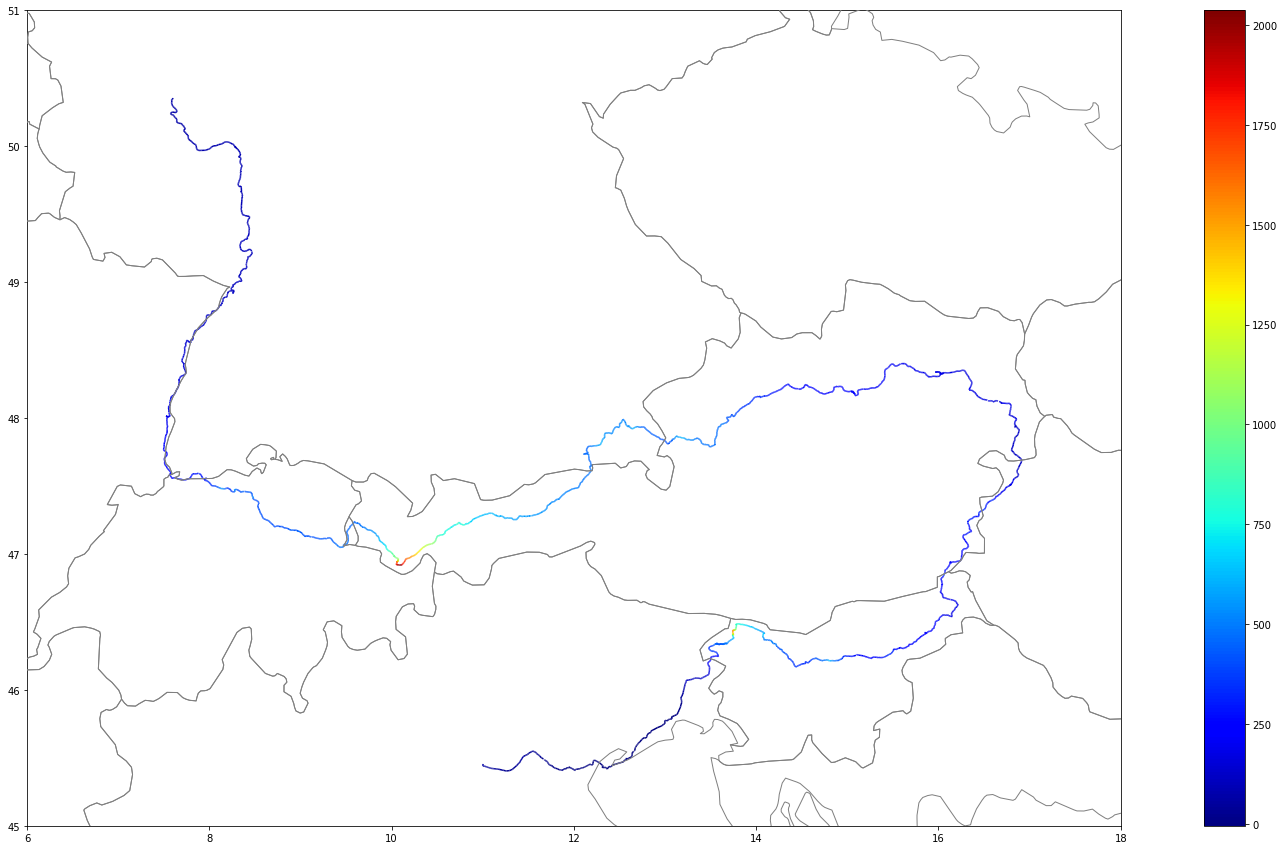

In [ ]:
worldboarder = my_folder + '/EuropeMap.shp'

countries = gpd.read_file(worldboarder)

siz = [(20, 15), (30, 15), (30, 15)]

ax = countries.plot(figsize=siz[indx], color='none', edgecolor='grey', zorder=3)
full_data.plot(column='StartEle', ax=ax, cmap='jet', legend=True)
x = [[-10.5, 1], [-10.5, 8], [6, 18]]
y = [[42, 51], [48, 55], [45, 51]]

ax.set_xlim(x[indx])
ax.set_ylim(y[indx])


We make an interactive map using folium

In [ ]:
import folium
import datetime
from folium import Choropleth, Circle, Marker, Vega
import branca.colormap as cm
import numpy as np
import altair
import json

locs = [[46, -2], [49.225, 2.798], [48, 12]]

m_1 = folium.Map(location = locs[indx], tiles='openstreetmap', zoom_start=6)

full_data['coords'] = full_data.apply(lambda x: tuple(y for y in x['geometry'].coords[0])[::-1], axis=1)
camp_data['coords'] = camp_data.apply(lambda x: [y for y in x['geometry'].coords[0]][::-1], axis=1)
corr_data = full_data.fillna(0)

cols = [['lightgreen', 'green'], ['lightblue', 'blue'], ['mistyrose', 'darkred']]
col = cm.LinearColormap(colors=cols[indx], vmin=0,vmax=full_data['StartEle'].max())

folium.ColorLine(positions=full_data['coords'], colors=corr_data['StartEle'], colormap=col, weight = 5).add_to(m_1)

#input start points for days

for idx, row in camp_data.iterrows():
  date = row['Date'] + datetime.timedelta(1)
  #Filter by date
  dets = full_data[full_data['Date'] == date]
  #Calcualte distance for the day
  dis = dets['Dist'].sum()/1000
  #calculate daily profile
  dets = dets.dropna(axis=0, subset=['StartEle'])
  dis_day = (np.cumsum(np.array(dets['Dist'])) - dets['Dist'].min()) / 1000
  ele_day = np.array(dets['StartEle'])
  arr = np.array([dis_day, ele_day]).T
  pp = pd.DataFrame(arr, columns=['Distance (km)', 'Elevation (m)'])

  if dis > 0:
    profile = altair.Chart(pp).mark_line().encode(
        x='Distance (km)',
        y='Elevation (m)')
    
    profile_json = json.loads(profile.to_json())
    #pop = folium.Popup(row['DayNum'] + ' Distance: ' + str(round(dis, 2)))
    pop = folium.Popup(max_width=500)
    folium.features.VegaLite(profile_json, width=300, height=300).add_to(pop)
    marker = folium.Marker(row['coords']).add_to(m_1)
    pop.add_to(marker)


m_1
